# DESCRIPTION OF THE METHOD
The following work is an implementation of a Time Series Data Generator.
The model name is PSA-GAN, which stands for Progressive Self-Attention GAN. In particular, the model is composed by two elements, 
the Generator and the Discriminator; the architecture of the latter mirrors the architecture of the first.
The generator takes as input a batch of sequences concatenated to a noise vector and an embedding of the sequences themselves, 
then it maps the concatenated matrix into a latent space of smaller size, and then the network produces future sequences of size smaller 
or equal to the one of the input.
The generator contains n blocks where each doubles the size of the output, by linear interpolation. 
Each block is composed by the following functions:
1. upscaling
2. main block
3. concatenation with the time features matrix

The main block is composed by:
- 1d convolution
- Spectral Normalization
- Leaky ReLU
- Residual Self-Attention

The residual self-attention is regulated by a parameter called gamma, and it starts from zero and its absolute value increases in time, 
as the network learns more "distant" features over time. 
This mechanism saves memory compared to networks that use recurrent cells.
The last layer is a 1d convolution which transforms the output from a multivariate sequence to a univariate sequence.

The discriminator contains n blocks where each halves the size of the input, by average pooling.
Each block is composed by the following functions:
1. Downscaling
2. Main block

In the end the input seqeunce is mapped into a score by using a Fully Connected layer and the Spectral Normalization.

$Y_{1} → Y_{0} = SN(FC(LR(SN(c(m(Y_{1}))))))$

The architecture is able to produce longer sequences by increasing the number of blocks. So long as the addition of blocks destabilizes the training due to the random initialization of the new untrained parameters, the *Progressive fade-in* technique is introduced in order to smoothly add a new block.

$\tilde{Z}_{i−1} → \tilde{Z}_{i} = αm(UP(\tilde{Z}_{i−1})) + (1 − α) UP(\tilde{Z}_{i−1})$

The α parameter is a scalar which is initialized to 0 when a new block is added and then grows linearly to one with epochs.

As preprocessing, a MinMax Normalization and a sliding window are used to prepare the train set and the real future sequences.
The architecture is trained via *Least Square GAN loss* (LSGAN) and the auxiliary *Moment Loss* (ML) in order to match the first and second order  moments between between the generated samples and the real samples, according to the formula:

$ML(\hat{Z}_{τ} , Z_{τ})=|µ(\hat{Z}_{τ}) − µ(Z_{τ})| + |σ(\hat{Z}_{τ}) − σ(Z_{τ})| $

Where µ and σ are respectively the mean and the standard deviation operator.

The main metric used to evaluate the model's performances is the *Context-FID score* (Context-Frechet Inception distance). In order to use it, an Embedder is needed, so a Long-Short memory Neural Network (Franceschi embedder) was trained on the dataset by using a special Triplet Loss.




# IMPORTS

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils
import plotting
import lstm
import metrics
import torch.nn as nn
import progressive_blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam


# Loading training set
The training dataset is loaded from a local  "*.csv*"  file into a PandasDataset. It consists of time series of monthly data already separated from the test set, with a total of 48000 data.
Then the dataset's features are transformed by using the "*MinMaxScaler*" according to the following formulation:  

$X_{std} = \frac{(X - X.min(axis=0))}{(X.max(axis=0) - X.min(axis=0))} $

$X_{scaled} = X_{std} * (max - min) + min $



Any missing value: V2    False
dtype: bool
all training set length:  48000


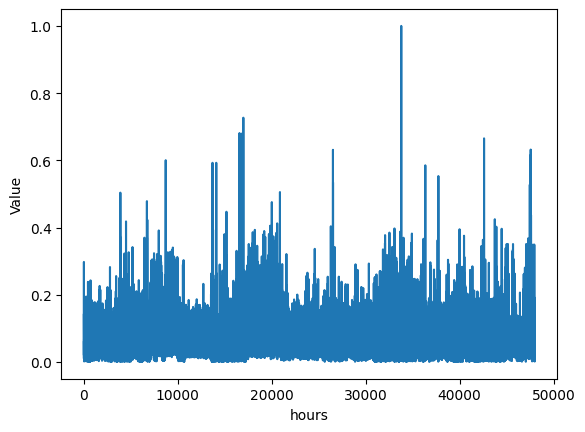

In [2]:
path="Models/M4/"

training_set = pd.read_csv('./Datasets/M4-Dataset/Train/Monthly-train.csv')  #load the train dataset

training_set = training_set.iloc[:,1:2]             #electricity values in time
any_missing_train = training_set.isnull().any()
print("Any missing value:",any_missing_train)
print("all training set length: ",len(training_set))

sc = MinMaxScaler()                       
training_set = sc.fit_transform(training_set)        #normalize

plotting.plot_dataset(training_set, x_axis="hours", y_axis="Value")

# Loading Test Set

Any missing value: V2    False
dtype: bool
all testing set length:  48000


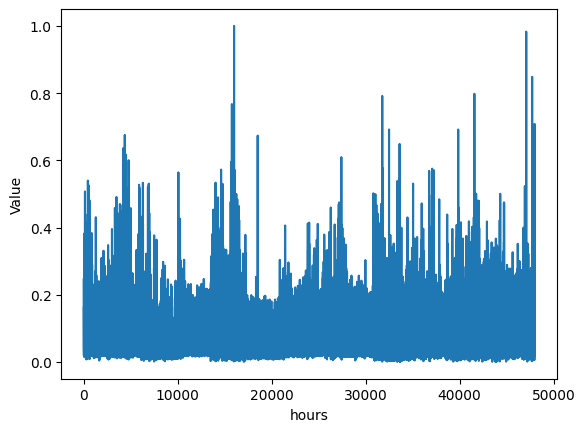

In [3]:

testing_set = pd.read_csv('./Datasets/M4-Dataset/Test/Monthly-test.csv')    #load the test dataset

testing_set = testing_set.iloc[:,1:2]                             #electricity values in time
any_missing_test = testing_set.isnull().any()
print("Any missing value:",any_missing_train)
print("all testing set length: ",len(testing_set))

sc = MinMaxScaler()
testing_set = sc.fit_transform(testing_set)                        #normalize

plotting.plot_dataset(testing_set, x_axis="hours", y_axis="Value")

## Creating sequences train

In [4]:
seq_length = 512 #it is tau in the paper

train_set=training_set[:42500]           
print("train_set.shape:",train_set.shape)

x_train, y_train = utils.sliding_windows(train_set, seq_length) #create the train-set by sliding a window of size tau starting from the first sample 
trainX=torch.Tensor(np.array(x_train))
print("trainX.shape:",trainX.shape)
size=trainX.size(0)                 #number of sequences(samples) 

sequences_train=utils.real_seq(training_set,seq_length) #create the real-sequences(labels) by sliding a window of size tau starting from the tau-th sample 
sequences_train=sequences_train[:size]  #we take just the first train-size sequences

sequences_train=torch.Tensor(sequences_train)
sequences_train.unsqueeze(0).unsqueeze(1)         #transform in 3-dim tensor
sequences_train=sequences_train.permute(0,2,1)
print("Sequences_train.shape",sequences_train.shape)


train_set.shape: (42500, 1)
trainX.shape: torch.Size([41987, 512, 1])
Sequences_train.shape torch.Size([41987, 1, 512])


## Creating sequences test

In [5]:

test_set=testing_set[:42500]
print(test_set.shape)

x_test, y_test= utils.sliding_windows(test_set, seq_length)
testX=torch.Tensor(np.array(x_test))
print("testX.shape:",testX.shape)
size=testX.size(0)

sequences_test=utils.real_seq(testing_set,seq_length)
sequences_test=sequences_test[:size]

sequences_test=torch.Tensor(sequences_test)
sequences_test.unsqueeze(0).unsqueeze(1)
sequences_test=sequences_test.permute(0,2,1)
print("Sequences_test.shape",sequences_test.shape)



(42500, 1)
testX.shape: torch.Size([41987, 512, 1])
Sequences_test.shape torch.Size([41987, 1, 512])


In [6]:

utils.create_folder(path)


Directory already exists: Models/M4/


# *TRAIN*

In [7]:
#main function to train the model with the hyperparameters as input

def train_GAN(
    trainX,                #train-set
    sequences_train,       #real-sequences(labels)
    seq_length,            #tau
    batch_size,            #dimension of the batch
    discriminator_lr,      
    generator_lr,
    num_epochs,           
    blocks_to_add,         #number of blocks we want to add during the training 
    timestamp,             #how often we add blocks 
    ml,                    #boolean for the moment loss
    fade_in,               #boolean for the fade-in
    sa,                    #boolean for self-attention
    save,   
    name,                  #name of the model to save
    gpu,
    path,
):
    embedding_dim=10       #size of the embedder used in the generator to concatenate the input (taken from the paper)
    value_features=1       #size of the value kernel of the self-attention-layer
    key_features=1         #size of the key kernel of the self-attention-layer

    #extract the number of features
    num_features=trainX.size(2)+10 

    criterion = nn.MSELoss()

    device=utils.assign_device(gpu)

    #Initializations
    train = TensorDataset(trainX, sequences_train)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=False) 

    
    D=progressive_blocks.Discriminator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features,sa,device)
    G=progressive_blocks.Generator(embedding_dim,seq_length,num_features,batch_size,value_features,key_features,sa,device)
    optimD = Adam(D.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))
    optimG = Adam(G.parameters(), lr=generator_lr, betas=(0.9, 0.999))
    embedder=torch.load("Models/Embedder/embedder_model.pt").to(device)

    activeG=(G.step-1)-blocks_to_add
    activeD=blocks_to_add

    utils.create_folder(path+'/'+name+'/')

    #Training
    g_losses = []
    d_losses = []
    fids = []
    G.to(device)
    D.to(device)
    fade=1
    sum_fade=0
    g_loss_min=1000000
    d_loss_min=1000000

    print()
    print("Starting training:",name)
    print("Total Epochs: %d \nBlocks to add with fade: %d\nTimestamp to add blocks: %d" % 
                        (num_epochs, blocks_to_add, timestamp))
    print()
    for epoch in range(1,num_epochs+1):
            g_losses_temp=[]
            d_losses_temp=[]
            fids_temp=[]
            if (epoch%timestamp==0 and activeG!=G.step-1 and activeD!=0 and fade_in==True):  #addition of the new block
                activeD-=1     
                activeG+=1
                fade=0                         #initialize fade
                sum_fade=1/((timestamp)/2)     #increasing of the fade
                print("Block added")

            elif(fade+sum_fade<=1 and fade_in==True):
                fade+=sum_fade                 #fade update

            else:
                fade=1

            for i, (X, Y) in enumerate((train_loader)):
                X=X.to(device)
                Y=Y.to(device)

                # Generate fake data
                fake_data = G(X,fade,activeG)
                fake_label = torch.zeros(Y.size(0))
                
            
                # Train the discriminator
                Y=Y[:,:,:fake_data.size(2)]  #we use this to adapt real sequences length to fake sequences length
            
                D.zero_grad()
                d_real_loss = criterion(D(Y,X,fade,activeD), torch.ones_like(D(Y,X,fade,activeD)))
                d_fake_loss = criterion(D(fake_data.detach(),X,fade,activeD), torch.zeros_like(D(fake_data.detach(),X,fade,activeD)))
                d_loss = d_real_loss + d_fake_loss
                d_losses_temp.append(d_loss.item())
                d_loss.backward(retain_graph=False)
                optimD.step()
                
                # Train the generator
                G.zero_grad()
                g_loss = criterion(D(fake_data,X,fade,activeD), torch.ones_like(D(fake_data,X,fade,activeD)))

                if(ml==True):
                    # Add the moment loss
                    g_loss += utils.moment_loss(fake_data, Y)

                g_losses_temp.append(g_loss.item())

                g_loss.backward()
                optimG.step()
                
                #Compute FID
                with torch.no_grad():
                    fake_embedding=embedder(fake_data)
                    real_embedding=embedder(Y) 
                    fid = metrics.calculate_fid(fake_embedding.to("cpu").detach().numpy(),real_embedding.to("cpu").detach().numpy())
                    
                fids_temp.append(fid)    

                # Print the losses
                if (i+1) % 1 == 0:
                    print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [Fade-in: %f] [FID: %f]" % 
                        (epoch, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item(), fade, fid))
                '''
                if(g_loss<g_loss_min and d_loss<d_loss_min and save):    #partial training 
                        g_loss_min = g_loss
                        d_loss_min = d_loss
                        torch.save(G, path+name+'/'+name+'_generator.pt')
                        torch.save(D, path+name+'/'+name+'_discriminator.pt')
                        print('Improvement-Detected, model saved')
                '''

            g_losses.append(torch.mean(torch.Tensor(g_losses_temp)))
            d_losses.append(torch.mean(torch.Tensor(d_losses_temp)))
            fids.append(torch.mean(torch.Tensor(fids_temp)))
            
    values=['Last G loss: '+str(g_losses[-1].item()), 
            'Last D loss: '+str(d_losses[-1].item()),
            'Last FID: '+str(fids[-1].item()),
            'epochs: '+str(num_epochs),
            'ML: '+str(ml),
            'SA: '+str(sa),
            'Fade-in: '+str(fade_in),
            'Blocks to add: '+str(blocks_to_add),
            'Timestamp: '+str(timestamp),
            ]
    torch.save(G, path+name+'/'+name+'_generator.pt')
    torch.save(D, path+name+'/'+name+'_discriminator.pt')
    plotting.plot_training_history('PSA-GAN - M4 - '+name,d_losses, g_losses)
    plotting.plot_fid_history('PSA-GAN - M4 - '+name, fids)
    location=path+'/'+name+'/'+name
    utils.write_file(location, values)

    return D,G, d_losses, g_losses, fids

## Start training

Cuda enabled: using GPU
Directory already exists: Models/M4//15model/

Starting training: 15model
Total Epochs: 15 
Blocks to add with fade: 2
Timestamp to add blocks: 5

[Epoch 1/15] [Batch 1/347] [D loss: 1.556835] [G loss: 1.893657] [Fade-in: 1.000000] [FID: 0.000417]
[Epoch 1/15] [Batch 2/347] [D loss: 1.545570] [G loss: 1.856919] [Fade-in: 1.000000] [FID: 0.000468]
[Epoch 1/15] [Batch 3/347] [D loss: 1.544796] [G loss: 1.852739] [Fade-in: 1.000000] [FID: 0.000367]
[Epoch 1/15] [Batch 4/347] [D loss: 1.544278] [G loss: 1.850840] [Fade-in: 1.000000] [FID: 0.000340]
[Epoch 1/15] [Batch 5/347] [D loss: 1.543799] [G loss: 1.837851] [Fade-in: 1.000000] [FID: 0.000327]
[Epoch 1/15] [Batch 6/347] [D loss: 1.543298] [G loss: 1.837217] [Fade-in: 1.000000] [FID: 0.000346]
[Epoch 1/15] [Batch 7/347] [D loss: 1.542819] [G loss: 1.832914] [Fade-in: 1.000000] [FID: 0.000340]
[Epoch 1/15] [Batch 8/347] [D loss: 1.542329] [G loss: 1.820163] [Fade-in: 1.000000] [FID: 0.000369]
[Epoch 1/15] [Batch 9

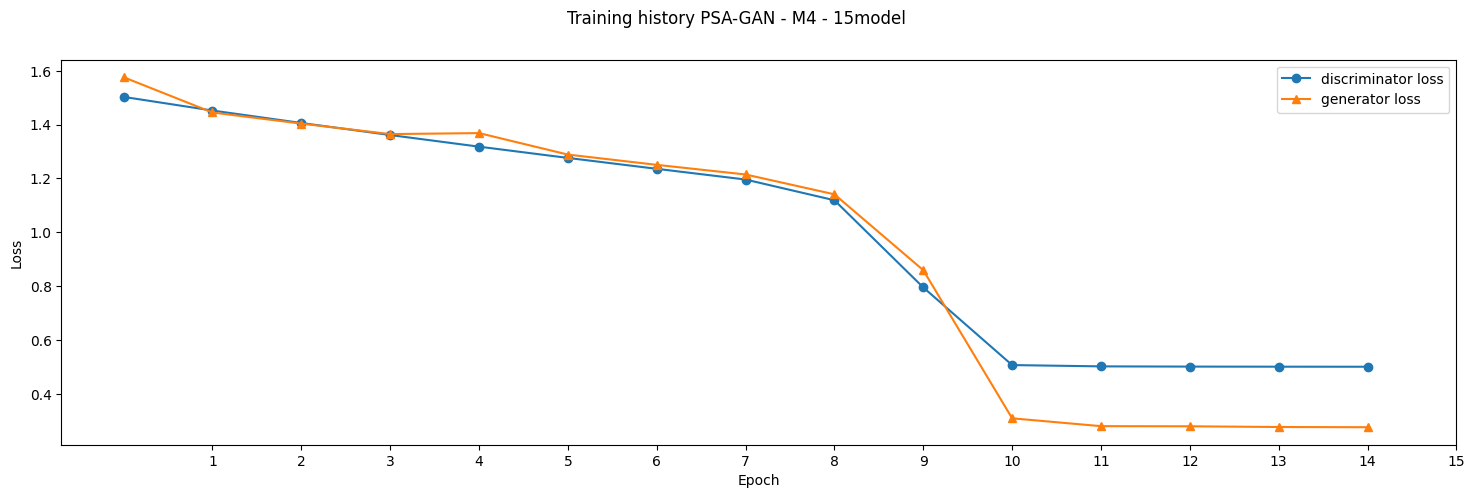

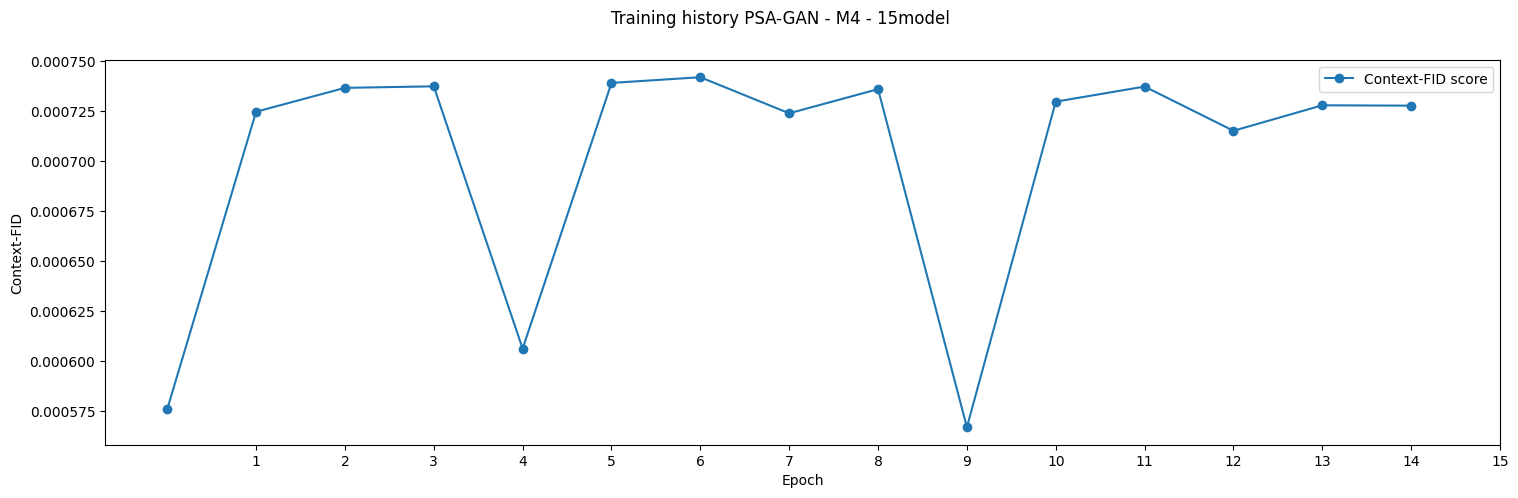

In [8]:
%%time

name_model="15model"
D,G, d_losses, g_losses, fids = train_GAN(
    trainX,
    sequences_train,
    seq_length=seq_length,
    #batch_size=347,
    batch_size=121,
    discriminator_lr=0.00005,
    generator_lr=0.00005,
    num_epochs=15,
    blocks_to_add=2,
    timestamp=5,
    ml=True,
    fade_in=True,
    sa=True,
    save=True,
    name=name_model,
    gpu=True,
    path=path,
)


LOAD MODEL

In [6]:
name_model="15model"
G,D = utils.load_model(path,name_model)

Model Loaded succesfully:  15model


Predictions on the train set


NRMSE on test set:  tensor(0.1772)


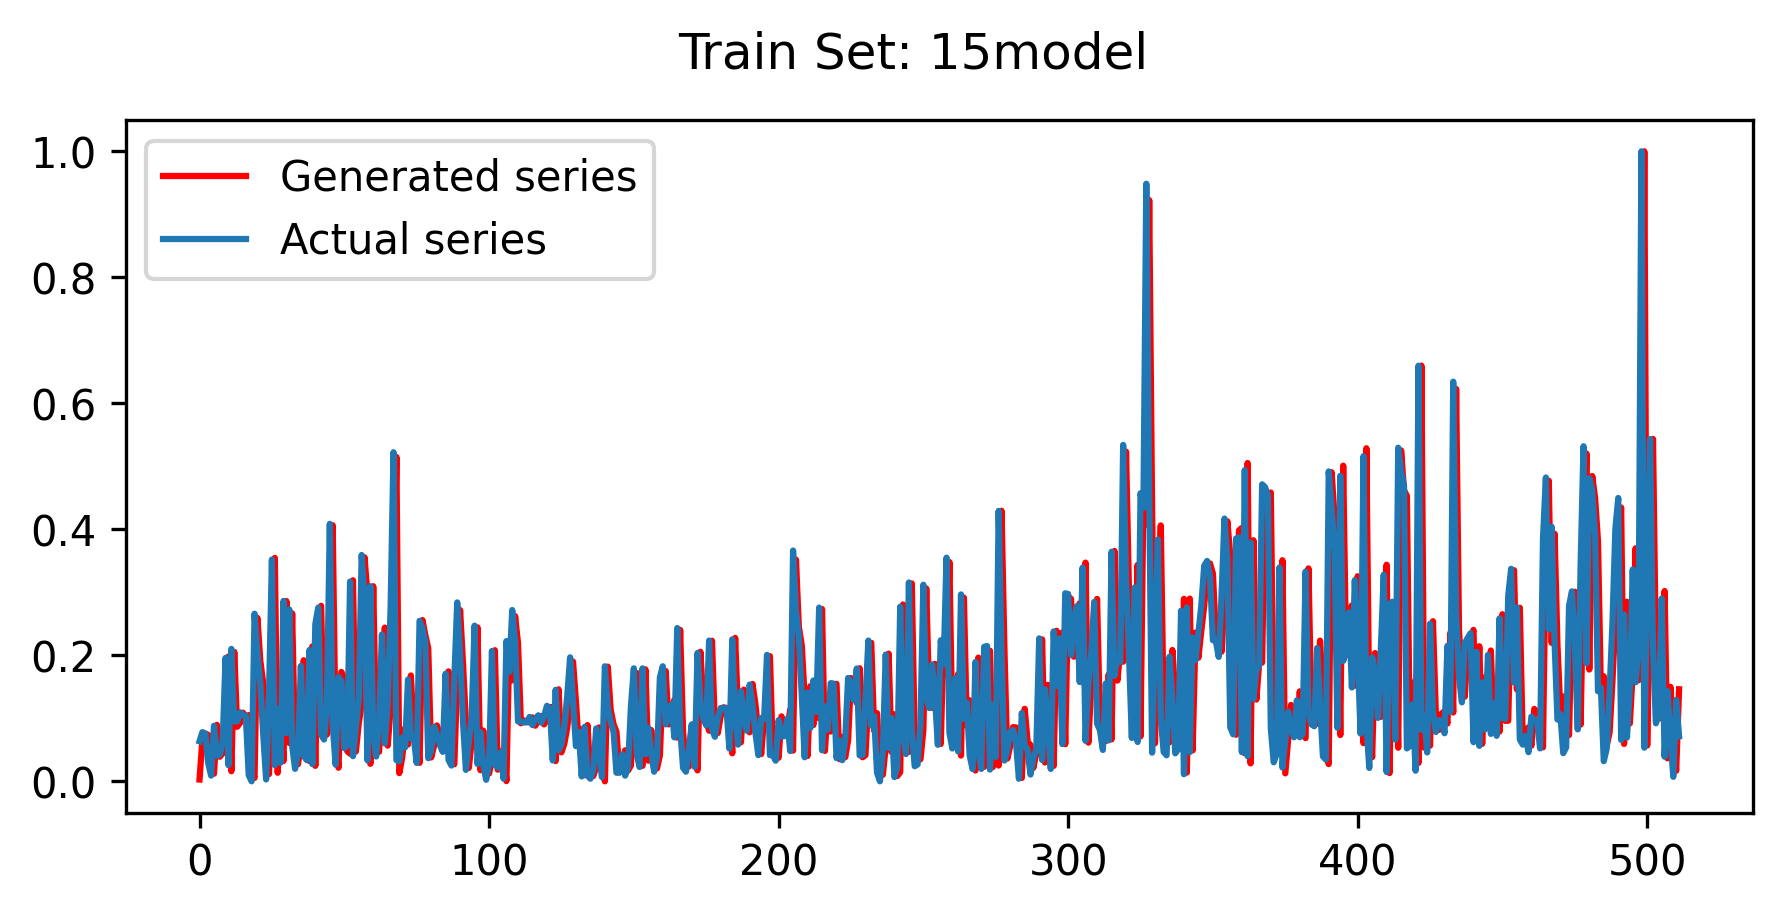

In [10]:
t = train_set[len(trainX):len(trainX)+seq_length]
#batch_size=347
batch_size=121
with torch.no_grad():
    
    generated_series = G(trainX[len(trainX)-batch_size:],1,(G.step-1)) 
    generated_series=generated_series.permute(0,2,1)
    #print("generated_series: ",generated_series.shape)
    generated_series = generated_series.to("cpu").detach().numpy()

generated_series[batch_size-1]=utils.scale(generated_series[batch_size-1])
aux=utils.scale(t)

nrmse=metrics.nrmse(torch.Tensor(generated_series), torch.Tensor(aux))
print("NRMSE on test set: ",nrmse)
plotting.plot_prediction(generated_series[batch_size-1], aux, 'Train Set: ',name_model)



Predictions on the Test set

NRMSE on test set:  tensor(0.2390)


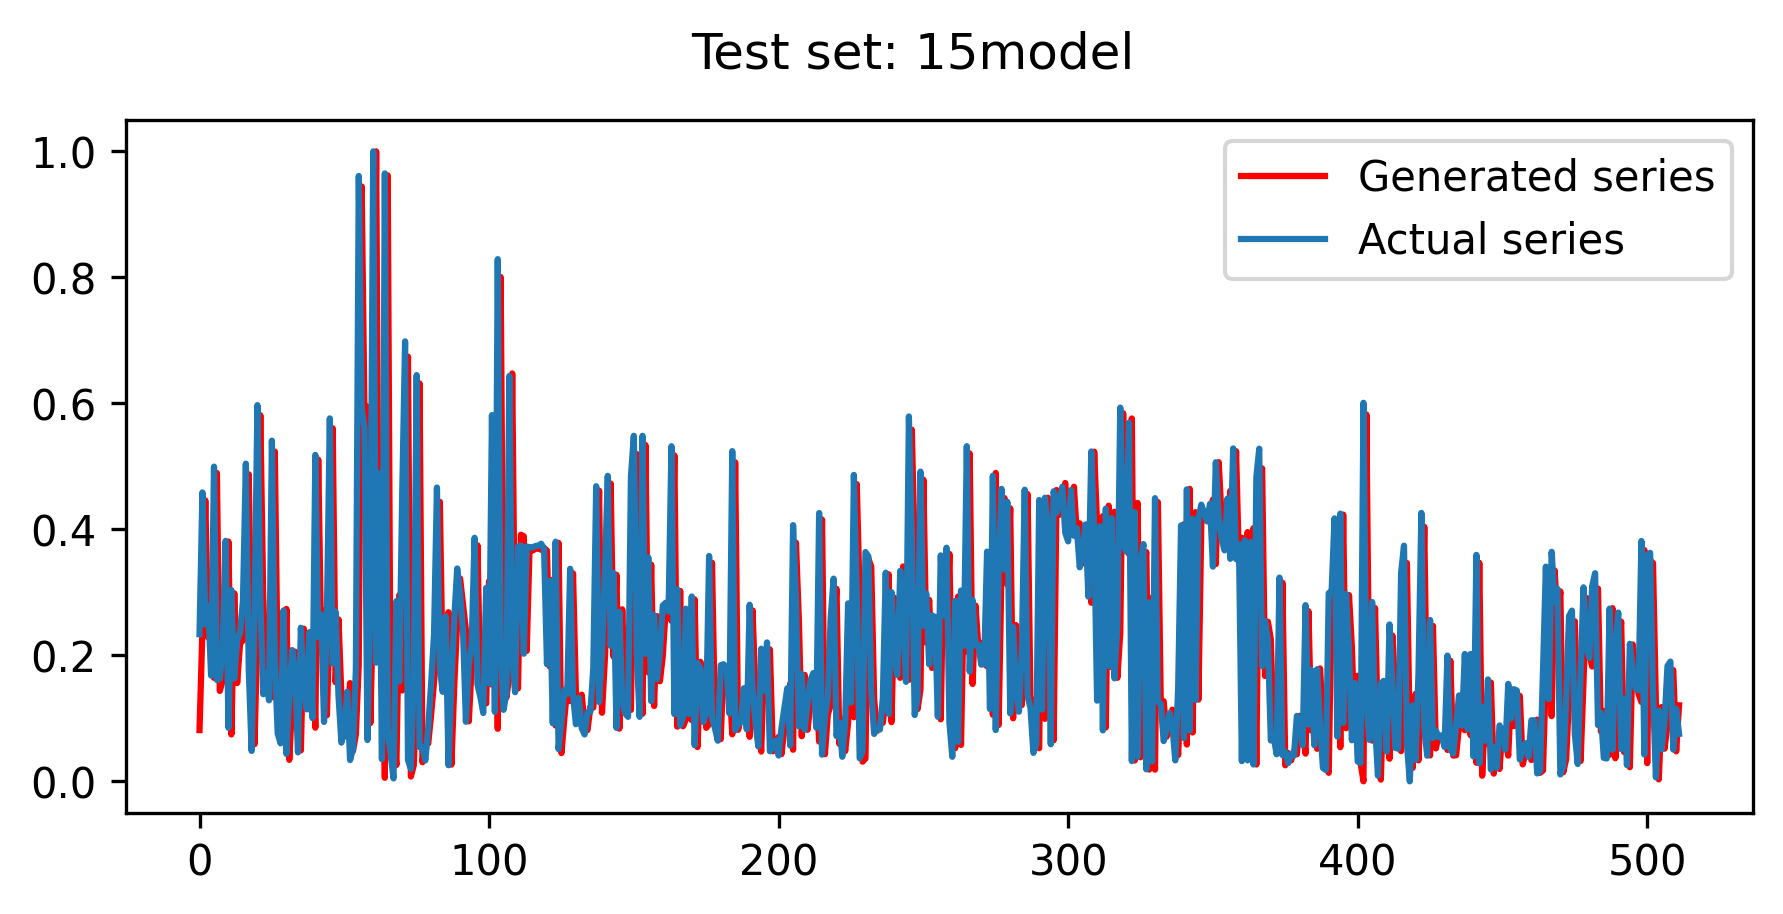

In [11]:

seq_length = 512 #it is tau in the paper

batch_size=121

t = test_set[len(testX):len(testX)+seq_length]

with torch.no_grad():
    
    generated_series = G(testX[len(testX)-batch_size:],1,(G.step-1)) 
    generated_series=generated_series.permute(0,2,1)
    #print("generated_series: ",generated_series.shape)
    generated_series = generated_series.to("cpu").detach().numpy()

generated_series[batch_size-1]=utils.scale(generated_series[batch_size-1])
aux=utils.scale(t)

nrmse=metrics.nrmse(torch.Tensor(generated_series), torch.Tensor(aux))
print("NRMSE on test set: ",nrmse)
plotting.plot_prediction(generated_series[batch_size-1], aux, "Test set: ", name_model)



# Evaluations

In [11]:
name_model="15model"
G,D = utils.load_model(path,name_model)
batch_size=121

Model Loaded succesfully:  15model


In [12]:

print("testX.shape",testX.shape)
print("sequence_test",sequences_test.shape)

train = TensorDataset(trainX, sequences_train)
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)

test= TensorDataset(testX, sequences_test)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False) 

testX.shape torch.Size([41987, 512, 1])
sequence_test torch.Size([41987, 1, 512])


## NRMSE

In [13]:
nrmse= metrics.evaluate_model(G,test_loader, "NRMSE")
print(name_model," NRMSE:",nrmse)

100%|██████████| 347/347 [00:07<00:00, 48.94it/s]

15model  NRMSE: 0.0020395410247147083


## CONTEXT - FID

it means if you sampled 95 data sets you'd expect the true mean to lie in that interval 95 of the time (but you wouldn't know which ones, so you can't say for any specific interval you compute that the mean will be there).

In [14]:
embedder = torch.load("Models/Embedder/embedder_model.pt")
#mean, std_dev, lower, upper = metrics.run_evaluation(G,G,G, test_loader, "FID",0.95, embedder)
mean, std_dev, lower, upper = metrics.run_evaluation1(G, test_loader, "FID", 0.95, embedder)
print("FID =",mean,"+-",upper," \nstd:",std_dev)

100%|██████████| 347/347 [01:48<00:00,  3.20it/s]

FID = 1.0089043969327212e-05 +- 1.0089043969327212e-05  
std: 0.0


# MAIN RESULTS

The hyperparameters used have been partially taken from the paper, and than was performed a hyperparameter tuning in order to adapt them to the hardware resources and to better perform on our smaller dataset.
The best results were obtained with this configuration:

- *epochs*: 10
- *seq_length* = seq_length,
- *batch_size* = 347,
- *discriminator lr* = 0.0005,
- *generator lr* = 0.0005,
- *Timestamp*: 5
- *Blocks to add*: 1
- *Moment Loss*: True
- *Self-attention*: True
- *Fade-in*: True

In the *"Ablation_study"* notebook is possible to see the other results obtained with different configurations of the hyperparameters, in particular how the architecture performs when we remove some components.

In order to have a better visualization on the plot, it was performed a local scaling on the predictions of the model and on the real sequences.
